## Oxparis Visualization Notebook
In this notebook one can load images and gt from the oxparis dataset as given by the POLD2 team (they were givin it by remi).
Possible actions in this Notebook:
- Load Images from the dataset and look at it and GT
- Run model on image and compare result with gt
- also detect lines

In [1]:
import torch
import flow_vis
import numpy as np
from matplotlib import pyplot as plt
from gluefactory.datasets import get_dataset
from gluefactory.models.deeplsd_inference import DeepLSD
from omegaconf import OmegaConf
from gluefactory.settings import DATA_PATH
import cv2
from copy import deepcopy

line_neighborhood = 5 # in px used to nortmalize/ denormalize df

/local/home/fmoeller/.local/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
def get_deep_lsd_model(device="cuda"):
    deeplsd_conf = {
    "detect_lines": True,
    "line_detection_params": {
        "merge": False,
        "filtering": True,
        "grad_thresh": 3,
        "grad_nfa": True,
    },
    "weights": "DeepLSD/weights/deeplsd_md.tar",  # path to the weights of the DeepLSD model (relative to DATA_PATH)
    }
    deeplsd_conf = OmegaConf.create(deeplsd_conf)

    ckpt_path = DATA_PATH / deeplsd_conf.weights
    ckpt = torch.load(str(ckpt_path), map_location=device, weights_only=False)
    deeplsd_net = DeepLSD(deeplsd_conf)
    deeplsd_net.load_state_dict(ckpt["model"])
    deeplsd_net = deeplsd_net.to(device).eval()
    return deeplsd_net

Define utility functions

In [3]:
def get_flow_vis(df, ang, line_neighborhood=5):
    norm = line_neighborhood + 1 - np.clip(df, 0, line_neighborhood)
    flow_uv = np.stack([norm * np.cos(ang), norm * np.sin(ang)], axis=-1)
    flow_img = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    return flow_img

def normalize_df(df):
    return -torch.log(df / line_neighborhood + 1e-6)

def denormalize_df(df_norm):
    return torch.exp(-df_norm) * line_neighborhood

def visualize_img_and_pred(keypoints,heatmap,distance_field,angle_field,img):
    _, ax = plt.subplots(1, 4, figsize=(20, 20))
    ax[0].axis('off')
    ax[0].set_title('Heatmap')
    ax[0].imshow(heatmap)

    ax[1].axis('off')
    ax[1].set_title('Distance Field')
    ax[1].imshow(distance_field)

    ax[2].axis('off')
    ax[2].set_title('Angle Field')
    ax[2].imshow(get_flow_vis(distance_field, angle_field))

    ax[3].axis('off')
    ax[3].set_title('Original')
    ax[3].imshow(img.permute(1,2,0))
    ax[3].scatter(keypoints[:,1],keypoints[:,0], marker="o", color="red", s=3)
    plt.show()
    

In [4]:
dset_conf = {
            "reshape": [600, 600], # ex [800, 800]
            "load_features": {
                "do": True,
                "check_exists": True,
                "point_gt": {
                    "data_keys": ["superpoint_heatmap"],
                    "use_score_heatmap": False,
                },
                "line_gt": {
                    "data_keys": ["deeplsd_distance_field", "deeplsd_angle_field"],
                },
            },
            "debug": True
        }
oxpa_2 = get_dataset("oxford_paris_mini_1view_jpldd")(dset_conf)
ds = oxpa_2.get_dataset(split="train")

# load one test element
elem = ds[0]
print(f"Keys: {elem.keys()}")

# print example shapes
af = elem["deeplsd_angle_field"]
df = elem["deeplsd_distance_field"]
hmap = elem["superpoint_heatmap"]
orig_pt = elem["orig_points"]

print(f"AF: type: {type(af)}, shape: {af.shape}, min: {torch.min(af)}, max: {torch.max(af)}")
print(f"DF: type: {type(df)}, shape: {df.shape}, min: {torch.min(df)}, max: {torch.max(df)}")
print(f"KP-HMAP: type: {type(hmap)}, shape: {hmap.shape}, min: {torch.min(hmap)}, max: {torch.max(hmap)}, sum: {torch.sum(hmap)}")

[10/21/2024 21:59:36 gluefactory.datasets.base_dataset INFO] Creating dataset OxfordParisMiniOneViewJPLDD
[10/21/2024 21:59:36 gluefactory.datasets.oxford_paris_mini_1view_jpldd INFO] NUMBER OF IMAGES: 12000


DATASET OVERALL(NO-SPLIT) IMAGES: 12000


[10/21/2024 21:59:36 gluefactory.datasets.oxford_paris_mini_1view_jpldd INFO] NUMBER OF IMAGES WITH GT: 12000


Keys: dict_keys(['name', 'scales', 'image_size', 'transform', 'original_image_size', 'image', 'orig_points', 'superpoint_heatmap', 'deeplsd_distance_field', 'deeplsd_angle_field'])
AF: type: <class 'torch.Tensor'>, shape: torch.Size([600, 600]), min: 0.0, max: 3.141592502593994
DF: type: <class 'torch.Tensor'>, shape: torch.Size([600, 600]), min: 0.34535685181617737, max: 4.999999523162842
KP-HMAP: type: <class 'torch.Tensor'>, shape: torch.Size([600, 600]), min: 0.0, max: 0.9269689321517944, sum: 506.48846435546875


## Run a model to get predictions

Define utility for visualisation and example calculation

In [5]:
def compute_and_visualize(img_data_with_gt, model, device):
    img_torch = img_data_with_gt["image"].to(device).unsqueeze(0)
    with torch.no_grad():
        output_model = model({"image": img_torch})
    jpldd_kpjhm = output_model['keypoint_and_junction_score_map'][0].cpu()
    jpldd_af = output_model['line_anglefield'][0].cpu()
    jpldd_df = output_model['line_distancefield'][0].cpu()
    jpldd_kp = output_model['keypoints'][0].cpu()
        
    af_gt = img_data_with_gt["deeplsd_angle_field"].cpu()
    df_gt = img_data_with_gt["deeplsd_distance_field"].cpu()
    hmap_gt = img_data_with_gt["superpoint_heatmap"].cpu()
    orig_pt_gt = img_data_with_gt["orig_points"].cpu()
    
    _, ax = plt.subplots(2, 4, figsize=(20, 8))
    ax[0, 0].axis('off')
    ax[0, 0].set_title('GT-Heatmap')
    ax[0, 0].imshow(hmap_gt)

    ax[0, 1].axis('off')
    ax[0, 1].set_title('GT-Distance Field')
    ax[0, 1].imshow(df_gt)

    ax[0, 2].axis('off')
    ax[0, 2].set_title('GT-Angle Field')
    ax[0, 2].imshow(get_flow_vis(df_gt, af_gt))

    ax[0, 3].axis('off')
    ax[0, 3].set_title('GT-Original')
    ax[0, 3].imshow(img_data_with_gt["image"].permute(1,2,0))
    ax[0, 3].scatter(orig_pt_gt[:, 0], orig_pt_gt[:, 1], marker="o", color="red", s=3)
    
    ax[1, 0].axis('off')
    ax[1, 0].set_title('KP&J Heatmap')
    ax[1, 0].imshow(jpldd_kpjhm)

    ax[1, 1].axis('off')
    ax[1, 1].set_title('Distance Field')
    ax[1, 1].imshow(jpldd_df)

    ax[1, 2].axis('off')
    ax[1, 2].set_title('Angle Field')
    ax[1, 2].imshow(get_flow_vis(jpldd_df, jpldd_af))

    ax[1, 3].axis('off')
    ax[1, 3].set_title('Original w. detected kp')
    ax[1, 3].imshow(img_torch.cpu().squeeze(0).permute(1,2,0))
    ax[1, 3].scatter(jpldd_kp[:, 0], jpldd_kp[:, 1], marker="o", color="red", s=3)
    plt.show()
    return output_model

In [12]:
from gluefactory.models import get_model

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_built():
    device = 'mps'
else:
    device = 'cpu'
print(f"Device Used: {device}")

DEBUG_DIR = "tmp_testbed"
jpldd_conf = {
    "name": "joint_point_line_extractor",
    "max_num_keypoints": 500,  # setting for training, for eval: -1
    "timeit": True,  # override timeit: False from BaseModel
    "line_df_decoder_channels": 32,
    "line_af_decoder_channels": 32,
    "line_detection": {
        "do": True,
        "conf": {
            "max_point_size": 1500,
            "min_line_length": 20,
            "max_line_length": None,
            "samples": [8],

            "distance_map": {
                "max_value": 5,
                "threshold": 0.5,
                "smooth_threshold": 0.85,
                "avg_filter_size": 13,
                "avg_filter_padding": 6,
                "avg_filter_stride": 1,
                "inlier_ratio": 0.9,
                "max_accepted_mean_value": 0.3,
            },

            "mlp_conf": {
                "has_angle_field": True,
                "has_distance_field": True, 
                "num_bands": 3,
                "band_width": 1,
                "num_line_samples": 150,
                "mlp_hidden_dims": [256, 128, 128, 64, 32],
                "pred_threshold": 0.95,
                "weights": "/local/home/Point-Line/outputs/training/pold2_mlp_train_1k_150samp/checkpoint_best.tar",
            },
            "nms": True,
            "debug": False,
            "debug_dir": DEBUG_DIR,
        }
    },
    "checkpoint": "/local/home/Point-Line/outputs/training/focal_loss_experiments/rk_focal_threshDF_focal/checkpoint_best.tar"
    #"checkpoint": "/local/home/rkreft/shared_team_folder/outputs/training/rk_oxparis_focal_hard_gt/checkpoint_best.tar"
    #"checkpoint": "/local/home/rkreft/shared_team_folder/outputs/training/rk_pold2gt_oxparis_base_hard_gt/checkpoint_best.tar"
}
jpldd_model_150 = get_model("joint_point_line_extractor")(jpldd_conf).to(device)
jpldd_model_150.eval()
conf2 = deepcopy(jpldd_conf)
conf2["line_detection"]["conf"]["mlp_conf"]["num_line_samples"] = 30
conf2["line_detection"]["conf"]["mlp_conf"]["weights"] = "/local/home/Point-Line/outputs/training/pold2_mlp_train_1k_30samp/checkpoint_best.tar"
jpldd_model_30 = get_model("joint_point_line_extractor")(conf2).to(device)
jpldd_model_30.eval()

Load model parameters from checkpoint /local/home/Point-Line/outputs/training/focal_loss_experiments/rk_focal_threshDF_focal/checkpoint_best.tar


Device Used: cuda


[10/21/2024 22:26:11 gluefactory.models.lines.pold2_mlp INFO] Successfully loaded model weights from /local/home/Point-Line/outputs/training/pold2_mlp_train_1k_150samp/checkpoint_best.tar
Load model parameters from checkpoint /local/home/Point-Line/outputs/training/focal_loss_experiments/rk_focal_threshDF_focal/checkpoint_best.tar
[10/21/2024 22:26:16 gluefactory.models.lines.pold2_mlp INFO] Successfully loaded model weights from /local/home/Point-Line/outputs/training/pold2_mlp_train_1k_30samp/checkpoint_best.tar


JointPointLineDetectorDescriptor(
  (encoder_backbone): AlikedEncoder(
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (pool4): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (gate): SELU(inplace=True)
    (block1): ConvBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): ResBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn

## Timings
Here we run some fw passes for single images and print timings. Check settings of model and dataset to interpret results correctly. Results are given as mean seconds.

In [8]:
from pprint import pprint
import random

rand_idx = random.sample(range(0, len(ds)), 300) 

for i in rand_idx:
    img_torch = ds[i]["image"].to(device).unsqueeze(0)
    with torch.no_grad():
        output_model = jpldd_model_150({"image": img_torch})

timings=jpldd_model_150.get_current_timings(reset=True)
pprint(timings)
print(f"~FPS: {1 / (timings['total-makespan'])} using device {device}")

{'descriptor-branch': np.float64(0.0016819238662719727),
 'encoder': np.float64(0.0054035186767578125),
 'keypoint-and-junction-heatmap': np.float64(0.0014085769653320312),
 'keypoint-detection': np.float64(0.0008242130279541016),
 'line-af': np.float64(0.006174802780151367),
 'line-detection': np.float64(0.008301496505737305),
 'line-df': np.float64(0.006178021430969238),
 'total-makespan': np.float64(0.0322268009185791)}
~FPS: 31.030073463590025 using device cuda


In [28]:
output_model.keys()

dict_keys(['keypoint_and_junction_score_map', 'line_anglefield', 'line_distancefield', 'keypoints_raw', 'keypoints', 'keypoint_scores', 'descriptors', 'lines', 'valid_lines'])

## Comparing JPLDD and DeepLSD lines

In [ ]:
# should use 544
img_index = 506
deeplsd_net = get_deep_lsd_model()
avg_lines_150 = 0
avg_lines_30 = 0
num_samples = 300
for i in range(num_samples):
    with torch.no_grad():
        img_torch = ds[i]["image"].to(device).unsqueeze(0)
        img = (img_torch[0].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
        c_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        gray_img = cv2.cvtColor(c_img, cv2.COLOR_BGR2GRAY)
        inputs = {
            "image": torch.tensor(gray_img, dtype=torch.float, device=device)[
                None, None
            ]
            / 255.0
        }
        deeplsd_output = deeplsd_net(inputs)
        deeplsd_lines = np.array(deeplsd_output["lines"][0]).astype(int)
        output_model = jpldd_model_150({"image": img_torch})
    
    deeplsd_lines_torch = torch.clamp(torch.tensor(deeplsd_lines).cuda(),0,599)
    keypoints_deeplsd = torch.cat((deeplsd_lines_torch[:,0],deeplsd_lines_torch[:,1]))
    line_data  = {
        "points": keypoints_deeplsd,
        "distance_map": output_model["line_distancefield"][0],
        "angle_map": output_model["line_anglefield"][0],
        "descriptors": torch.zeros((keypoints_deeplsd.shape[0],128)).cuda(), 
    }
    avg_lines_deeplsd += len(deeplsd_lines)
    avg_lines_150 += len(jpldd_model_150.line_extractor(line_data)["lines"])

print(f"Avg lines deeplsd: {avg_lines_deeplsd//num_samples}")
print(f"Avg lines JPLDD (150 samples): {avg_lines_150//num_samples}")
del jpldd_model_150

## 150 samples vs 30 samples (num lines)

In [13]:
avg_lines_150 = 0
avg_lines_30 = 0
num_samples = 500
for i in range(num_samples):
    with torch.no_grad():
        img_torch = ds[i]["image"].to(device).unsqueeze(0)
        output_model_150 = jpldd_model_150({"image": img_torch})
        output_model_30 = jpldd_model_30({"image": img_torch})
    
    avg_lines_30 += len(output_model_30["lines"][0])
    avg_lines_150 += len(output_model_150["lines"][0])
print(f"Avg lines JPLDD (30 samples): {avg_lines_30//num_samples}")
print(f"Avg lines JPLDD (150 samples): {avg_lines_150//num_samples}")

Avg lines JPLDD (30 samples): 53
Avg lines JPLDD (150 samples): 50


## 30 vs 150 samples (timing)

In [14]:
from pprint import pprint

jpldd_model_150.get_current_timings(reset=True)
num_samples = 500
for i in range(num_samples):
    img_torch = ds[i]["image"].to(device).unsqueeze(0)
    with torch.no_grad():
        output_model = jpldd_model_150({"image": img_torch})

timings=jpldd_model_150.get_current_timings(reset=True)
pprint(timings)
print(f"~FPS: {1 / (timings['total-makespan'])} using device {device}")

{'descriptor-branch': np.float64(0.0016859769821166992),
 'encoder': np.float64(0.0053920745849609375),
 'keypoint-and-junction-heatmap': np.float64(0.0014081001281738281),
 'keypoint-detection': np.float64(0.0008263587951660156),
 'line-af': np.float64(0.006181955337524414),
 'line-detection': np.float64(0.02024531364440918),
 'line-df': np.float64(0.0061833858489990234),
 'total-makespan': np.float64(0.044205665588378906)}
~FPS: 22.62153474424525 using device cuda


In [15]:
from pprint import pprint

jpldd_model_30.get_current_timings(reset=True)
num_samples = 500
for i in range(num_samples):
    img_torch = ds[i]["image"].to(device).unsqueeze(0)
    with torch.no_grad():
        output_model = jpldd_model_30({"image": img_torch})

timings=jpldd_model_30.get_current_timings(reset=True)
pprint(timings)
print(f"~FPS: {1 / (timings['total-makespan'])} using device {device}")

{'descriptor-branch': np.float64(0.0016865730285644531),
 'encoder': np.float64(0.005391359329223633),
 'keypoint-and-junction-heatmap': np.float64(0.0014088153839111328),
 'keypoint-detection': np.float64(0.0008265972137451172),
 'line-af': np.float64(0.006180763244628906),
 'line-detection': np.float64(0.020911335945129395),
 'line-df': np.float64(0.006183147430419922),
 'total-makespan': np.float64(0.0448908805847168)}
~FPS: 22.27623933802832 using device cuda


Seems like 150 vs 30 samples does not really make a difference regarding time. But using 30 samples makes the model detect a few more lines

# Harris Corners

In [28]:
# should use 544
img_index = 123
deeplsd_net = get_deep_lsd_model()
with torch.no_grad():
    img_torch = ds[img_index]["image"].to(device).unsqueeze(0)
    img = (img_torch[0].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    c_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    gray_img = cv2.cvtColor(c_img, cv2.COLOR_BGR2GRAY)
    inputs = {
            "image": torch.tensor(gray_img, dtype=torch.float, device=device)[
                None, None
            ]
            / 255.0
        }
    deeplsd_output = deeplsd_net(inputs)
    output_model = jpldd_model_150({"image": img_torch})
deeplsd_lines = np.array(deeplsd_output["lines"][0]).astype(int)
deeplsd_lines_torch = torch.tensor(deeplsd_lines).cuda()
keypoints_deeplsd = torch.cat((deeplsd_lines_torch[:,0],deeplsd_lines_torch[:,1]))
dst = cv2.cornerHarris(gray_img,3,3,0.04)
dst_norm = np.empty(dst.shape,dtype=np.float32)
cv2.normalize(dst,dst_norm,alpha=0,beta=255,norm_type=cv2.NORM_MINMAX)
dst_norm_scaled = cv2.convertScaleAbs(dst_norm)
keypoints_harris = torch.Tensor(np.transpose(np.where(dst_norm_scaled > 200))).cuda()
output_model = jpldd_model_30({"image": img_torch})

keypoints_overall = torch.cat((keypoints_harris,output_model["keypoints"][0]))

line_data  = {
    "points": keypoints_overall,
    "distance_map": output_model["line_distancefield"][0],
    "angle_map": output_model["line_anglefield"][0],
    "descriptors": torch.zeros((keypoints_overall.shape[0],128)).cuda(), 
}
cur_lines = jpldd_model_30.line_extractor(line_data)["lines"]
keypoints_deeplsd = keypoints_deeplsd.cpu().numpy()

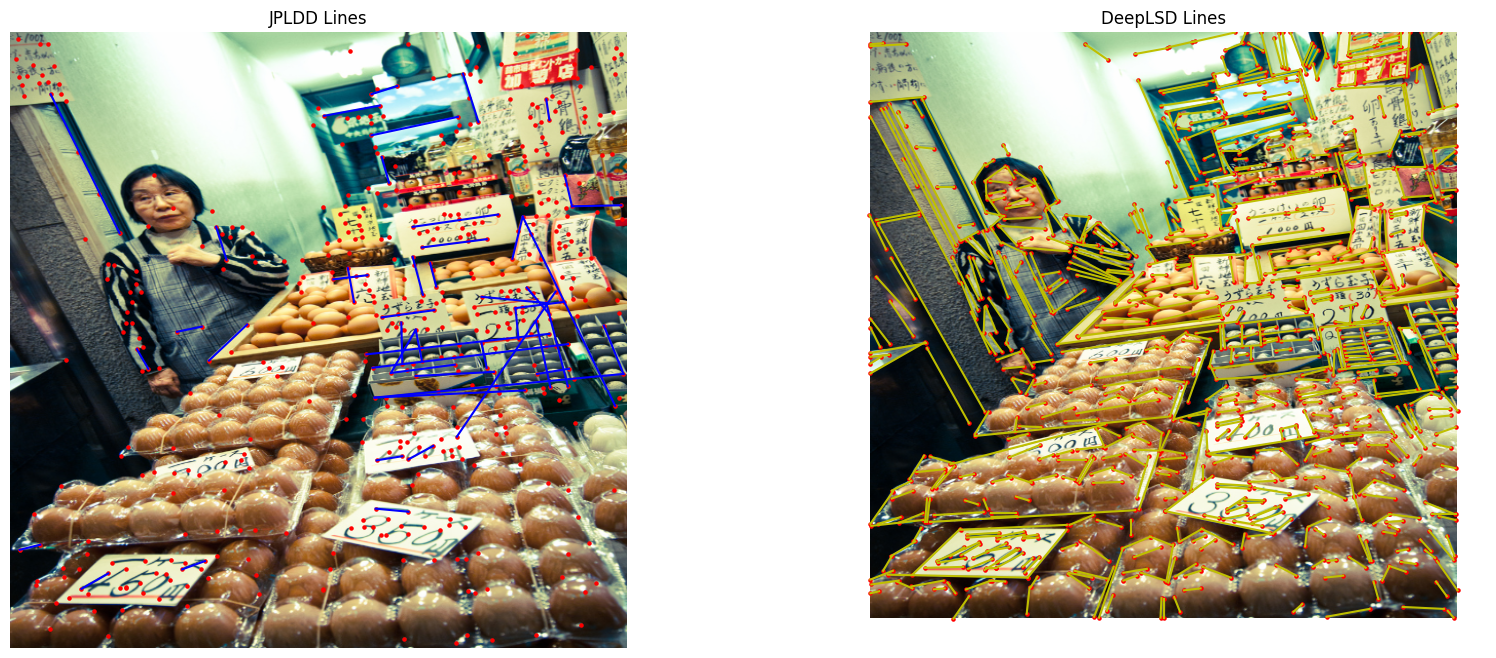

In [29]:
lines_jpldd = cur_lines.cpu().numpy()
keypoints = keypoints_overall.cpu().numpy()
_, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].axis('off')
ax[0].set_title("JPLDD Lines")
ax[0].scatter(keypoints[:,0],keypoints[:,1],s=5,c="r")
ax[0].imshow(ds[img_index]["image"].permute(1, 2, 0))
for i in range(lines_jpldd.shape[0]):
    line = lines_jpldd[i]
    x1,y1 = line[0]
    x2,y2 = line[1]
    ax[0].plot([x1,x2],[y1,y2],'b-')
ax[1].axis('off')
ax[1].set_title("DeepLSD Lines")
ax[1].scatter(keypoints_deeplsd[:,0],keypoints_deeplsd[:,1],s=5,c="r")
ax[1].imshow(ds[img_index]["image"].permute(1, 2, 0))
for i in range(deeplsd_lines.shape[0]):
    line = deeplsd_lines[i]
    x1,y1 = line[0]
    x2,y2 = line[1]
    plt.plot([x1,x2],[y1,y2],'y-')